In [1]:
%reload_ext autoreload
%autoreload 2
    
from tqdm import tqdm

import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from matplotlib import pyplot as plt

import tasks
import models

In [20]:
import torch
import snntorch as snn
from snntorch import surrogate


In [30]:
D = 1
lif = snn.Synaptic(beta=torch.rand(D), learn_beta=True, alpha=torch.rand(D), learn_alpha=True)

print("Beta:", lif.beta)
print("Alpha:", lif.alpha)

optimizer = torch.optim.Adam(lif.parameters(), lr=0.01)

v = torch.randn(D)
print(v)

def increase_output(lif, optimizer):
    mem = torch.zeros(D)
    syn = torch.zeros(D)
    
    total_spikes = torch.zeros(D)
    for _ in range(100):
        spk, syn, mem = lif(v, syn=syn, mem=mem)
        total_spikes += spk

    loss = total_spikes.sum()
    loss.backward()

    optimizer.step()
    return total_spikes

num_epochs = 100
all_spikes = torch.zeros((num_epochs, D))
for epoch in range(num_epochs):
    all_spikes[epoch] = increase_output(lif, optimizer)

print("Beta:", lif.beta)
print("Alpha:", lif.alpha)

Beta: Parameter containing:
tensor([0.1807], requires_grad=True)
Alpha: Parameter containing:
tensor([0.9893], requires_grad=True)
tensor([0.6926])
Beta: Parameter containing:
tensor([-0.8271], requires_grad=True)
Alpha: Parameter containing:
tensor([-0.0185], requires_grad=True)


In [110]:
lif = snn.Synaptic(beta=0.5, learn_beta=True, alpha=0.0, learn_alpha=True)

NS = 1000
num_peaks = 20
weight = torch.nn.Parameter(torch.tensor(0.5))
recurrent = torch.nn.Parameter(torch.tensor(0.5))

params = list(lif.parameters()) + [weight, recurrent]
opt = torch.optim.Adam(params, lr=0.01)

print("Weight:", weight.item(), "Recurrent:", recurrent.item(), "Beta:", lif.beta.item(), "Alpha:", lif.alpha.item())

loss_function = lambda x, t: (torch.sum(x) - t)**2

def sim_epoch(lif, opt, num_peaks, weight, recurrent, NS):
    opt.zero_grad()
    input = torch.sin(2*torch.pi*torch.arange(NS).float()/NS*num_peaks)
    spks = torch.zeros(NS)
    syns = torch.zeros(NS)
    mems = torch.zeros(NS)
    syn = torch.tensor(0.0)
    mem = torch.tensor(0.0)
    spk = torch.tensor(0.0)
    for step in range(NS):
        spk, syn, mem = lif(weight * input[step] + recurrent * spk, syn=syn, mem=mem)
        spks[step] = spk
        syns[step] = syn
        mems[step] = mem
        
    loss = loss_function(spks, num_peaks)
    loss.backward()
    opt.step()
    return loss, spks, syns, mems

num_epochs = 100
total_spikes = torch.zeros(num_epochs)
all_loss = torch.zeros(num_epochs)
all_weights = torch.zeros(num_epochs)
all_recurrents = torch.zeros(num_epochs)
all_num_peaks = torch.zeros(num_epochs)

for epoch in tqdm(range(num_epochs)):
    num_peaks = torch.randint(15, 26, (1,))
    loss, spks, syns, mems = sim_epoch(lif, opt, num_peaks, weight, recurrent, NS)
    all_loss[epoch] = loss.item()
    total_spikes[epoch] = spks.sum()
    all_weights[epoch] = weight.item()
    all_recurrents[epoch] = recurrent.item()
    all_num_peaks[epoch] = num_peaks.item()

print("Weight:", weight.item(), "Recurrent:", recurrent.item(), "Beta:", lif.beta.item(), "Alpha:", lif.alpha.item())

Weight: 0.5 Recurrent: 0.5 Beta: 0.5 Alpha: 0.0


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]

Weight: 0.5041060447692871 Recurrent: 0.38089999556541443 Beta: 0.5051455497741699 Alpha: 0.005145545117557049


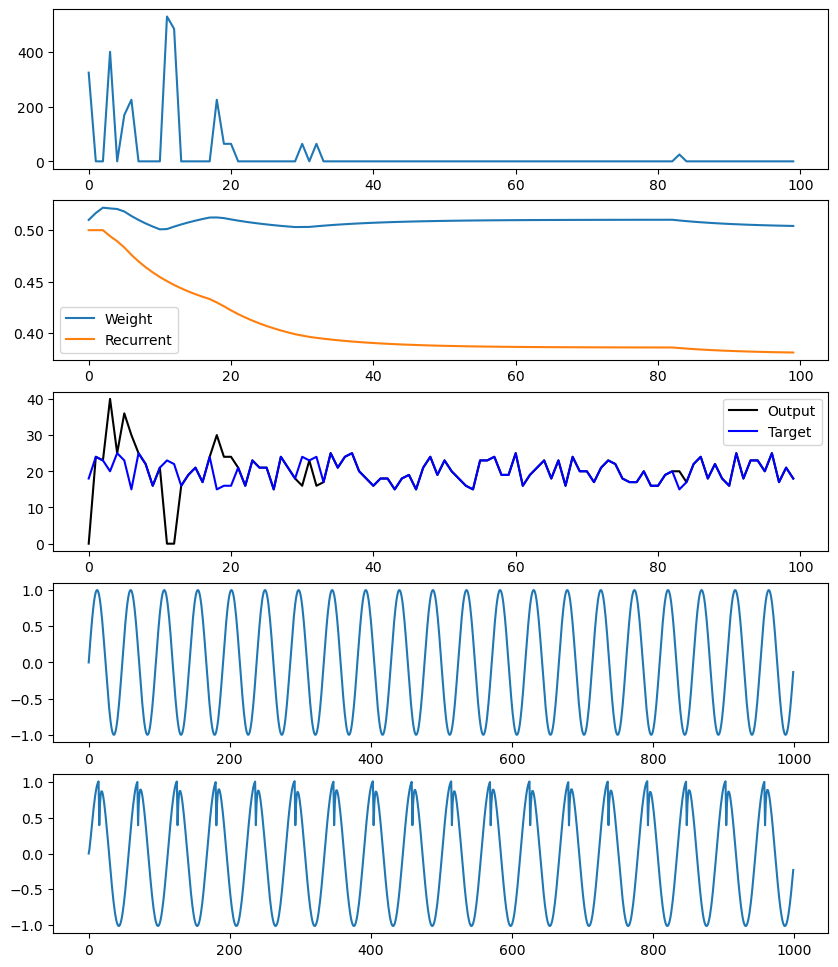

In [111]:
fig, ax = plt.subplots(5, 1, figsize=(10, 12), sharex=False)
ax[0].plot(all_loss)
ax[1].plot(all_weights, label="Weight")
ax[1].plot(all_recurrents, label="Recurrent")
ax[1].legend()
ax[2].plot(total_spikes.detach(), color='k', label="Output")
ax[2].plot(all_num_peaks, color='b', label="Target")
ax[2].legend()

ax[3].plot(input)
ax[4].plot(mems.detach())
plt.show()

In [81]:
lif = snn.Synaptic(beta=torch.rand(D), learn_beta=True, alpha=torch.rand(D), learn_alpha=True)
total_spikes = torch.zeros(D)
syn = torch.zeros(D)
mem = torch.zeros(D)
for _ in range(10):
    spk, syn, mem = lif(v, syn=syn, mem=mem)
    print(mem.item(), syn.item())
    total_spikes += spk

0.6925868391990662 0.6925868391990662
1.0545594692230225 1.028009057044983
0.24374032020568848 1.2033137083053589
0.819974958896637 0.8106311559677124
1.1211373805999756 1.0897035598754883
0.27853643894195557 1.2355575561523438
0.8381607532501221 0.827483057975769
1.1306419372558594 1.098510980606079
0.28350400924682617 1.2401607036590576
0.8407569527626038 0.8298888206481934


In [5]:
# Hyperparameters
B = 100 # Batch size
D = 10 # Input dimensions
N = 20 # Number of recurrent neurons
T = 10 # Time steps per trial
sigma = 2.0  # Noise amplitude
learning_rate = 1e-3
num_epochs = 1000
num_contexts = 3

task = tasks.ContextualGoNogo(D, sigma, num_contexts)
start_integration = task.decision_start_time()

# Create network
net = models.SpikingRNN(task.input_dimensionality(), N, 2, beta=2.0, synaptic=False)

# Loss function and optimizer
def loss_function(outputs, labels, spks, alpha=1.0):
    target_loss = nn.CrossEntropyLoss()(outputs, labels)
    spike_loss = 0.1 * torch.sum(spks, dim=(1, 2))
    return target_loss + torch.mean(alpha * spike_loss)
   
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-2)


save_accuracy = torch.zeros(num_epochs)

# Training loop
for epoch in range(num_epochs):
    X, labels, params = task.generate_data(B, T)

    optimizer.zero_grad()
    outputs, spks, mems = net(X, start_integration=start_integration)
    loss = loss_function(outputs, labels, spks, alpha=1.0)
    loss = criterion(outputs, labels)  # Use only the last time step for loss
    loss.backward()
    optimizer.step()

    choice = torch.argmax(outputs, dim=1)
    accuracy = torch.sum(choice == labels).item() / B * 100
    save_accuracy[epoch] = accuracy
    
    if (epoch + 1) % (num_epochs // 10) == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')

X, labels, params = task.generate_data(B, T)
outputs, spks, mems = net(X, start_integration=start_integration)
choice = torch.argmax(outputs, dim=1)
print(f'Failures: Choice - Labels - EmpiricalS')
errors = torch.stack((choice, labels), dim=1)[choice != labels]
print(errors)
print(f'Accuracy: {torch.sum(choice == labels).item() / B * 100:.2f}%')

Epoch [100/1000], Loss: 0.6825, Accuracy: 53.00%
Epoch [200/1000], Loss: 0.6797, Accuracy: 63.00%
Epoch [300/1000], Loss: 0.6700, Accuracy: 75.00%
Epoch [400/1000], Loss: 0.6343, Accuracy: 88.00%
Epoch [500/1000], Loss: 0.6176, Accuracy: 85.00%
Epoch [600/1000], Loss: 0.6118, Accuracy: 76.00%
Epoch [700/1000], Loss: 0.5871, Accuracy: 81.00%
Epoch [800/1000], Loss: 0.5580, Accuracy: 87.00%
Epoch [900/1000], Loss: 0.5690, Accuracy: 82.00%
Epoch [1000/1000], Loss: 0.5590, Accuracy: 74.00%
Failures: Choice - Labels - EmpiricalS
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
      

torch.Size([13, 20]) torch.Size([20, 20])


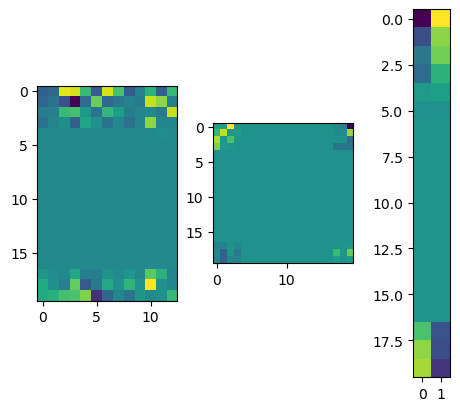

In [6]:
ipweight = net.input_weight.weight.detach().T
rcweight = net.recurrent_weight.weight.detach()
roweight = net.readout.weight.detach()
sd_score = roweight[0] - roweight[1]
isort = torch.argsort(sd_score)


print(ipweight.shape, rcweight.shape)

fig, ax = plt.subplots(1, 3, figsize=(5, 4), layout="constrained")
ax[0].imshow(ipweight.T[isort])
ax[1].imshow(rcweight.T[isort][:, isort])
ax[2].imshow(roweight.T[isort])
plt.show()

In [7]:
params["stimuli"].shape

KeyError: 'stimuli'

In [19]:
X, labels, params = task.generate_data(B)
outputs, spks, mems = net(X, start_integration=start_integration)
choice = torch.argmax(outputs, dim=1)

torch.cat((params["stimuli"][:10], labels[:10].unsqueeze(1), choice[:10].unsqueeze(1)), dim=1)

tensor([[0, 0, 1, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [0, 0, 1, 0],
        [1, 1, 1, 0],
        [0, 0, 1, 0],
        [1, 1, 1, 0]])

torch.Size([10, 13]) torch.Size([10, 20]) torch.Size([10, 20])


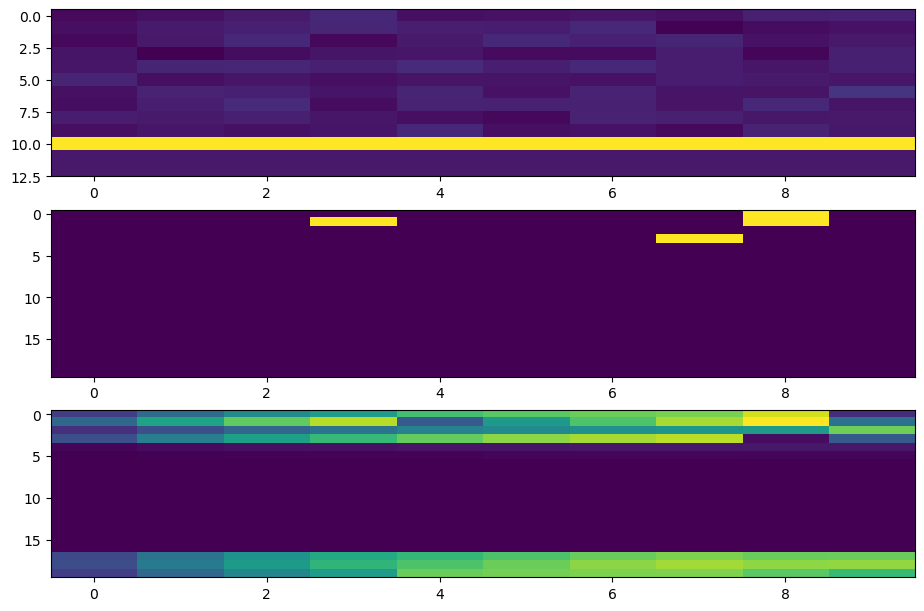

In [8]:
ibatch = 8

print(X[ibatch].shape, spks[ibatch].shape, mems[ibatch].shape)

fig, ax = plt.subplots(3, 1, figsize=(9, 6), layout="constrained")
ax[0].imshow(X[ibatch].T, aspect="auto")
ax[1].imshow(spks[ibatch][:, isort].detach().T, aspect="auto")
ax[2].imshow(mems[ibatch][:, isort].detach().T, aspect="auto")
plt.show()